<a href="https://colab.research.google.com/github/Mehedi16009/wemem-cifar10-privacy-defense/blob/main/11th_August_python_wemem_cifar10_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Step 1 — Install, imports, mount Google Drive
# (Optional) !pip install -U some-package  # not needed for this notebook

import os, copy, time, math, random, json
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.optim.lr_scheduler import MultiStepLR
from torchvision import transforms, models
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset, Subset

# Mount Google Drive (Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# reproducibility (best-effort)
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

torch.backends.cudnn.benchmark = True

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Mounted at /content/drive
Using device: cuda


In [2]:
# @title Step 2 — Paths & hyperparameters (edit these if you want to tune)

# Path where your "cifar-10-batches-py" folder is located in Drive.
# By default this notebook expects: /content/drive/MyDrive/cifar-10-batches-py
DRIVE_CIFAR_DIR = "/content/drive/MyDrive/cifar-10-batches-py"  # <-- change if needed
OUT_DIR = "/content/drive/MyDrive/wemem_results"
os.makedirs(OUT_DIR, exist_ok=True)

# Hyperparameters (demo-friendly defaults)
batch_size = 128
num_classes = 10

# Baseline training
base_epochs = 30          # increase to 100+ for final experiments
patience = 6              # early stopping

# Iterative pruning
prune_iterations = 5
prune_fraction_per_iter = 0.17
prune_finetune_epochs = 10

# memorization score (K-submodel)
K_submodels = 5
submodel_epochs = 3       # increase for stronger mem estimates

# WEMEM hyperparams
tau = 0.5
lambda_r = 1e-3
lambda_g = 1e-4

# LiRA demo params (VERY heavy for large values)
lira_num_targets = 20
lira_shadows_per_side = 4
lira_shadow_train_size = 5000   # smaller for demo
lira_shadow_epochs = 2

print("OUT_DIR:", OUT_DIR)
print("Drive CIFAR folder exists:", os.path.isdir(DRIVE_CIFAR_DIR))


OUT_DIR: /content/drive/MyDrive/wemem_results
Drive CIFAR folder exists: True


In [3]:
# @title Step 3 — Data transforms & load CIFAR-10 from Drive
# torchvision will locate the folder "cifar-10-batches-py" inside the provided parent root.

# Standard CIFAR-10 normalization
CIFAR_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR_STD  = (0.2023, 0.1994, 0.2010)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

transform_eval = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD)
])

if not os.path.isdir(DRIVE_CIFAR_DIR):
    raise FileNotFoundError(f"Folder not found at {DRIVE_CIFAR_DIR}. Put the CIFAR folder in Drive and re-run Step 1/2.")

root_parent = str(Path(DRIVE_CIFAR_DIR).parent)

# two dataset objects: one with augmentation (for training), one deterministic (for evaluation / mem-scores)
full_train_aug = CIFAR10(root=root_parent, train=True, transform=transform_train, download=False)
full_train_eval = CIFAR10(root=root_parent, train=True, transform=transform_eval, download=False)
testset = CIFAR10(root=root_parent, train=False, transform=transform_eval, download=False)

print("Loaded CIFAR-10 datasets. Total train examples:", len(full_train_aug))


Loaded CIFAR-10 datasets. Total train examples: 50000


In [4]:
# @title Step 4 — Train/Val split and DataLoaders
# Step 4: split train (50k) -> train (45k) + val (5k); create DataLoaders
N_total = len(full_train_aug)
assert N_total == 50000

all_indices = list(range(N_total))
random.shuffle(all_indices)
val_indices = all_indices[:5000]
train_indices = all_indices[5000:]

# Subsets and loaders
trainset = Subset(full_train_aug, train_indices)        # augmented training
valset = Subset(full_train_eval, val_indices)           # deterministic val
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train/Val/Test sizes:", len(trainset), len(valset), len(testset))


Train/Val/Test sizes: 45000 5000 10000


In [5]:
# @title Step 5 — Helper classes & model factory (IndexedSubset, evaluation, training loops)
# Step 5: helper classes & train/eval functions

# IndexedSubset returns (x, y, global_index) — used for mem-scores and adaptive regularization
class IndexedSubset(Dataset):
    def __init__(self, base_dataset, indices):
        self.dataset = base_dataset
        self.indices = list(indices)
    def __len__(self):
        return len(self.indices)
    def __getitem__(self, idx):
        gidx = self.indices[idx]
        x, y = self.dataset[gidx]
        return x, y, gidx

# model factory
def get_resnet18():
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)

# evaluation helper
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    loss_list = []
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                inputs, labels, _ = batch
            else:
                inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            out = model(inputs)
            loss_list.append(criterion(out, labels).item())
            preds = out.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct/total, float(np.mean(loss_list) if loss_list else 0.0)

# basic training with early stopping
def train_with_early_stopping(model, train_loader, val_loader, epochs=50, init_lr=0.1,
                              weight_decay=5e-4, patience=6, scheduler_milestones=None):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=weight_decay)
    if scheduler_milestones is None:
        scheduler_milestones = [int(0.5*epochs), int(0.75*epochs)]
    scheduler = MultiStepLR(optimizer, milestones=scheduler_milestones, gamma=0.1)

    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())
    no_improve = 0

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            if len(batch) == 3:
                inputs, labels, _ = batch
            else:
                inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            out = model(inputs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        val_acc, val_loss = evaluate(model, val_loader)
        if val_acc > best_acc + 1e-6:
            best_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping @ epoch {epoch+1}. Best val acc = {best_acc:.4f}")
                break
        if (epoch+1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} val_acc={val_acc:.4f} val_loss={val_loss:.4f}")
    model.load_state_dict(best_wts)
    return model


In [6]:
# @title Step 6 — Train baseline ResNet-18
# Step 6: train baseline ResNet-18 (this may take ~minutes depending on epochs)
print("Training baseline ResNet-18 ...")
base_model = get_resnet18()
base_model = train_with_early_stopping(base_model, trainloader, valloader, epochs=base_epochs, init_lr=0.1, patience=patience)
base_test_acc, _ = evaluate(base_model, testloader)
print("Baseline test accuracy:", base_test_acc)
torch.save(base_model.state_dict(), os.path.join(OUT_DIR, "base_resnet18.pth"))


Training baseline ResNet-18 ...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/30 val_acc=0.4118 val_loss=1.6246
Epoch 5/30 val_acc=0.6578 val_loss=0.9593
Epoch 10/30 val_acc=0.7184 val_loss=0.8163
Epoch 15/30 val_acc=0.7218 val_loss=0.8152
Epoch 20/30 val_acc=0.8278 val_loss=0.5159
Epoch 25/30 val_acc=0.8400 val_loss=0.4825
Epoch 30/30 val_acc=0.8416 val_loss=0.4795
Baseline test accuracy: 0.8313


In [7]:
# @title Step 7 — Iterative global L1 pruning + fine-tuning
# Step 7: iterative unstructured pruning (global L1) + fine-tuning
def iterative_prune_and_finetune(model, train_loader, val_loader, iterations=5, amount_each=0.17, finetune_epochs=10):
    pruned = copy.deepcopy(model)
    parameters_to_prune = []
    for name, m in pruned.named_modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            parameters_to_prune.append((m, 'weight'))
    history = []
    for it in range(iterations):
        print(f"\nPruning iteration {it+1}/{iterations}: removing fraction {amount_each}")
        prune.global_unstructured(parameters_to_prune, pruning_method=prune.L1Unstructured, amount=amount_each)
        # make pruning permanent
        for (m, pname) in parameters_to_prune:
            prune.remove(m, pname)
        # fine-tune after pruning
        pruned = train_with_early_stopping(pruned, train_loader, val_loader, epochs=finetune_epochs, init_lr=0.01, patience=3)
        # compute sparsity
        total_w = zero_w = 0
        for n,p in pruned.named_parameters():
            if 'weight' in n:
                total_w += p.numel()
                zero_w += (p==0).sum().item()
        sparsity = 100.0 * zero_w / total_w
        test_acc, _ = evaluate(pruned, testloader)
        print(f"End of iter {it+1}: sparsity={sparsity:.2f}% test_acc={test_acc:.4f}")
        history.append({'iter': it+1, 'sparsity': float(sparsity), 'test_acc': float(test_acc)})
    return pruned, history

print("Running iterative pruning + finetuning ...")
pruned_model, prune_history = iterative_prune_and_finetune(base_model, trainloader, valloader,
                                                          iterations=prune_iterations, amount_each=prune_fraction_per_iter,
                                                          finetune_epochs=prune_finetune_epochs)
torch.save(pruned_model.state_dict(), os.path.join(OUT_DIR, "pruned_model.pth"))
print("Pruning history:", prune_history)


Running iterative pruning + finetuning ...

Pruning iteration 1/5: removing fraction 0.17
Epoch 1/10 val_acc=0.8348 val_loss=0.5035
Early stopping @ epoch 5. Best val acc = 0.8384
End of iter 1: sparsity=13.96% test_acc=0.8267

Pruning iteration 2/5: removing fraction 0.17
Epoch 1/10 val_acc=0.8324 val_loss=0.5091
Epoch 5/10 val_acc=0.8304 val_loss=0.5069
Epoch 10/10 val_acc=0.8496 val_loss=0.4718
End of iter 2: sparsity=13.95% test_acc=0.8420

Pruning iteration 3/5: removing fraction 0.17
Epoch 1/10 val_acc=0.8278 val_loss=0.5295
Epoch 5/10 val_acc=0.8302 val_loss=0.5327
Epoch 10/10 val_acc=0.8558 val_loss=0.4598
End of iter 3: sparsity=13.95% test_acc=0.8452

Pruning iteration 4/5: removing fraction 0.17
Epoch 1/10 val_acc=0.8348 val_loss=0.5385
Epoch 5/10 val_acc=0.8378 val_loss=0.5210
Epoch 10/10 val_acc=0.8582 val_loss=0.4576
End of iter 4: sparsity=13.95% test_acc=0.8463

Pruning iteration 5/5: removing fraction 0.17
Epoch 1/10 val_acc=0.8422 val_loss=0.5056
Early stopping @ epoc

In [8]:
# @title Step 8 — Compute memorization scores (K-submodel Bayesian approximation)
# Step 8: compute mem-scores using K disjoint submodels trained on parts of the train pool
print("Computing memorization scores (K-submodel approx) ...")

def compute_mem_scores(full_dataset_eval, train_pool_indices, K=5, epochs_per_sub=3):
    N = len(full_dataset_eval)  # 50000
    mem_scores = np.zeros(N, dtype=np.float32)
    # partition train pool into K disjoint subsets
    pool = train_pool_indices.copy()
    random.shuffle(pool)
    subsets = np.array_split(pool, K)
    print("Subset sizes:", [len(s) for s in subsets])
    # train K submodels
    submodels = []
    for i in range(K):
        print(f"Training submodel {i+1}/{K} ...")
        loader = DataLoader(IndexedSubset(full_dataset_eval, subsets[i]), batch_size=batch_size, shuffle=True, num_workers=2)
        m = get_resnet18()
        opt = optim.SGD(m.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()
        m.train()
        for ep in range(epochs_per_sub):
            for xb, yb, _ in loader:
                xb, yb = xb.to(device), yb.to(device)
                opt.zero_grad()
                out = m(xb)
                loss = criterion(out, yb)
                loss.backward()
                opt.step()
        m.eval()
        submodels.append(m)
    # map global idx -> subset id (-1 if not in any subset)
    global_to_subset = -1 * np.ones(N, dtype=int)
    for sid, subset in enumerate(subsets):
        for g in subset:
            global_to_subset[g] = sid
    # evaluate submodels on full dataset in batches and compute mem-scores
    full_loader = DataLoader(full_dataset_eval, batch_size=batch_size, shuffle=False, num_workers=2)
    soft = nn.Softmax(dim=1)
    ptr = 0
    with torch.no_grad():
        for xb, yb in tqdm(full_loader, desc="mem compute"):
            xb, yb = xb.to(device), yb.to(device)
            b = yb.size(0)
            # collect probs for all submodels on this batch
            probs = torch.zeros((b, K, num_classes), device=device)
            for j, m in enumerate(submodels):
                out = m(xb)
                probs[:, j, :] = soft(out)
            # for each sample in batch
            for bi in range(b):
                g = ptr + bi
                sid = int(global_to_subset[g])
                if sid < 0:
                    mem_scores[g] = 0.0
                else:
                    label = int(yb[bi].item())
                    p_in = float(probs[bi, sid, label].item())
                    others = [jj for jj in range(K) if jj != sid]
                    p_out = float(probs[bi, others, label].mean().item()) if others else 0.0
                    mem_scores[g] = p_in - p_out
            ptr += b
    return mem_scores

mem_scores_raw = compute_mem_scores(full_train_eval, train_indices, K=K_submodels, epochs_per_sub=submodel_epochs)
# Normalize mem-scores to [0,1]
minv, maxv = float(mem_scores_raw.min()), float(mem_scores_raw.max())
if maxv - minv > 1e-12:
    mem_scores = (mem_scores_raw - minv) / (maxv - minv)
else:
    mem_scores = mem_scores_raw.copy()
np.save(os.path.join(OUT_DIR, "mem_scores.npy"), mem_scores)
print("Mem-scores saved. stats:", mem_scores.min(), mem_scores.mean(), mem_scores.max())


Computing memorization scores (K-submodel approx) ...
Subset sizes: [9000, 9000, 9000, 9000, 9000]
Training submodel 1/5 ...
Training submodel 2/5 ...
Training submodel 3/5 ...
Training submodel 4/5 ...
Training submodel 5/5 ...


mem compute: 100%|██████████| 391/391 [00:23<00:00, 16.86it/s]

Mem-scores saved. stats: 0.0 0.44998515 1.0


In [9]:
# @title Step 9 — Implement WEMEM defenses: RSW, RMR, SWMR (fine‑tune pruned model)
# Step 9: implement RSW, RMR, SWMR (fine-tune pruned model with each defense)

# Sliding window sampler for RSW and SWMR
class SlidingWindowSampler:
    def __init__(self, sorted_indices, window_width, step):
        self.sorted_indices = np.array(sorted_indices)
        self.win = int(window_width)
        self.step = int(step)
        self.N = len(self.sorted_indices)
        assert self.win <= self.N
    def get_indices_for_epoch(self, epoch):
        start = (epoch * self.step) % (self.N - self.win + 1)
        return self.sorted_indices[start: start + self.win].tolist()

# train_with_adaptive_l2 (used by RMR and SWMR)
def train_with_adaptive_l2(model, indices_pool, base_dataset_eval, mem_scores_arr,
                           epochs=5, window_sampler=None, tau=0.5, lambda_r=1e-3, lambda_g=1e-4, init_lr=0.01):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=0.0)
    scheduler = MultiStepLR(optimizer, milestones=[int(0.5*epochs)], gamma=0.1)
    for epoch in range(epochs):
        model.train()
        if window_sampler is None:
            epoch_indices = indices_pool
        else:
            epoch_indices = window_sampler.get_indices_for_epoch(epoch)
        loader = DataLoader(IndexedSubset(base_dataset_eval, epoch_indices), batch_size=batch_size, shuffle=True, num_workers=2)
        for xb, yb, gidx in loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            base_loss = criterion(out, yb)
            # L2 norm across weights
            l2 = torch.tensor(0., device=device)
            for p in model.parameters():
                l2 = l2 + (p**2).sum()
            # compute fraction of high-risk in batch
            mask = mem_scores_arr[gidx.numpy()] >= tau
            mask_mean = float(mask.mean()) if len(mask)>0 else 0.0
            lam = mask_mean * lambda_r + (1.0 - mask_mean) * lambda_g
            loss = base_loss + lam * l2
            loss.backward()
            optimizer.step()
        scheduler.step()
        if (epoch+1) % 2 == 0 or epoch == 0:
            val_acc, _ = evaluate(model, valloader)
            print(f"Adaptive epoch {epoch+1}/{epochs} val_acc={val_acc:.4f}")
    return model

# RSW: sliding-window sampling only
def fine_tune_rsw(pruned_model, mem_scores_arr, train_pool_indices, base_dataset_eval,
                  window_width=20000, step=2000, epochs=8, init_lr=0.01):
    sorted_desc = np.argsort(-mem_scores_arr)  # highest mem first
    # keep only train pool indices in sorted order
    train_set = set(train_pool_indices)
    sorted_train_desc = [i for i in sorted_desc if i in train_set]
    sampler = SlidingWindowSampler(sorted_train_desc, window_width=min(window_width,len(sorted_train_desc)), step=step)
    # RSW uses sliding windows, but here we do no extra per-sample L2 (lam set to lambda_g by default).
    model = copy.deepcopy(pruned_model)
    # We'll still use train_with_adaptive_l2 but lambda_r/lambda_g will modulate L2; using same function simplifies code.
    model = train_with_adaptive_l2(model, train_pool_indices, base_dataset_eval, mem_scores_arr,
                                   epochs=epochs, window_sampler=sampler, tau=tau, lambda_r=lambda_r, lambda_g=lambda_g,
                                   init_lr=init_lr)
    return model

# RMR: uniform sampling + adaptive L2
def fine_tune_rmr(pruned_model, mem_scores_arr, train_pool_indices, base_dataset_eval, epochs=8, init_lr=0.01):
    model = copy.deepcopy(pruned_model)
    model = train_with_adaptive_l2(model, train_pool_indices, base_dataset_eval, mem_scores_arr,
                                   epochs=epochs, window_sampler=None, tau=tau, lambda_r=lambda_r, lambda_g=lambda_g,
                                   init_lr=init_lr)
    return model

# SWMR: sliding window + adaptive L2
def fine_tune_swmr(pruned_model, mem_scores_arr, train_pool_indices, base_dataset_eval,
                   window_width=20000, step=2000, epochs=8, init_lr=0.01):
    sorted_desc = np.argsort(-mem_scores_arr)
    train_set = set(train_pool_indices)
    sorted_train_desc = [i for i in sorted_desc if i in train_set]
    sampler = SlidingWindowSampler(sorted_train_desc, window_width=min(window_width,len(sorted_train_desc)), step=step)
    model = copy.deepcopy(pruned_model)
    model = train_with_adaptive_l2(model, train_pool_indices, base_dataset_eval, mem_scores_arr,
                                   epochs=epochs, window_sampler=sampler, tau=tau, lambda_r=lambda_r, lambda_g=lambda_g,
                                   init_lr=init_lr)
    return model

# Run RSW, RMR, SWMR fine-tuning on the pruned model
print("Fine-tuning pruned model with RSW ...")
rsw_model = fine_tune_rsw(pruned_model, mem_scores, train_indices, full_train_eval,
                          window_width=min(20000, len(train_indices)), step=2000, epochs=8, init_lr=0.01)
acc_rsw, _ = evaluate(rsw_model, testloader)
print("RSW test acc:", acc_rsw)
torch.save(rsw_model.state_dict(), os.path.join(OUT_DIR, "rsw_model.pth"))

print("Fine-tuning pruned model with RMR ...")
rmr_model = fine_tune_rmr(pruned_model, mem_scores, train_indices, full_train_eval, epochs=8, init_lr=0.01)
acc_rmr, _ = evaluate(rmr_model, testloader)
print("RMR test acc:", acc_rmr)
torch.save(rmr_model.state_dict(), os.path.join(OUT_DIR, "rmr_model.pth"))

print("Fine-tuning pruned model with SWMR ...")
swmr_model = fine_tune_swmr(pruned_model, mem_scores, train_indices, full_train_eval,
                            window_width=min(20000, len(train_indices)), step=2000, epochs=8, init_lr=0.01)
acc_swmr, _ = evaluate(swmr_model, testloader)
print("SWMR test acc:", acc_swmr)
torch.save(swmr_model.state_dict(), os.path.join(OUT_DIR, "swmr_model.pth"))


Fine-tuning pruned model with RSW ...
Adaptive epoch 1/8 val_acc=0.8430
Adaptive epoch 2/8 val_acc=0.8428
Adaptive epoch 4/8 val_acc=0.8316
Adaptive epoch 6/8 val_acc=0.8536
Adaptive epoch 8/8 val_acc=0.8554
RSW test acc: 0.8397
Fine-tuning pruned model with RMR ...
Adaptive epoch 1/8 val_acc=0.8506
Adaptive epoch 2/8 val_acc=0.8304
Adaptive epoch 4/8 val_acc=0.8250
Adaptive epoch 6/8 val_acc=0.8544
Adaptive epoch 8/8 val_acc=0.8572
RMR test acc: 0.8412
Fine-tuning pruned model with SWMR ...
Adaptive epoch 1/8 val_acc=0.8460
Adaptive epoch 2/8 val_acc=0.8388
Adaptive epoch 4/8 val_acc=0.8214
Adaptive epoch 6/8 val_acc=0.8522
Adaptive epoch 8/8 val_acc=0.8504
SWMR test acc: 0.8422


In [10]:
# @title Step 10 — LiRA (faithful but heavy) — simplified demo & confidence baseline
# Step 10: LiRA-style attack (faithful but heavy). Also provide a simple confidence-based baseline.
# CAUTION: LiRA trains many shadow models; keep parameters small for Colab.

# Simple confidence-based membership attack (fast baseline)
def simple_confidence_attack(model, member_indices, nonmember_indices, full_dataset_eval, fpr_target=0.05):
    model.eval()
    soft = nn.Softmax(dim=1)
    def get_confs(indices):
        confs = []
        for i in range(0, len(indices), batch_size):
            idxs = indices[i:i+batch_size]
            loader = DataLoader(IndexedSubset(full_dataset_eval, idxs), batch_size=len(idxs), shuffle=False)
            for xb, yb, _ in loader:
                xb, yb = xb.to(device), yb.to(device)
                with torch.no_grad():
                    out = model(xb)
                    p = soft(out)
                    probs = p.gather(1, yb.view(-1,1)).cpu().numpy().reshape(-1)
                    confs.extend(probs.tolist())
        return np.array(confs)
    mem_conf = get_confs(member_indices)
    non_conf = get_confs(nonmember_indices)
    thresh = np.quantile(non_conf, 1.0 - fpr_target)
    tpr = float((mem_conf >= thresh).mean())
    return tpr, thresh

# Quick demo: sample 2k members / 2k nonmembers
members_sample = train_indices[:2000]
nonmembers_sample = val_indices[:2000]

print("Running simple confidence attack baseline ...")
tpr_pruned, thr = simple_confidence_attack(pruned_model, members_sample, nonmembers_sample, full_train_eval, fpr_target=0.05)
tpr_rsw, _ = simple_confidence_attack(rsw_model, members_sample, nonmembers_sample, full_train_eval, fpr_target=0.05)
tpr_rmr, _ = simple_confidence_attack(rmr_model, members_sample, nonmembers_sample, full_train_eval, fpr_target=0.05)
tpr_swmr, _ = simple_confidence_attack(swmr_model, members_sample, nonmembers_sample, full_train_eval, fpr_target=0.05)
print("Confidence-attack TPR @ FPR=0.05 -> pruned:", tpr_pruned, "RSW:", tpr_rsw, "RMR:", tpr_rmr, "SWMR:", tpr_swmr)

# (Optional) Faithful LiRA: heavy — only run if you understand the compute cost.
# I can add the full LiRA cell if you want; it will train many shadow models per target sample.


Running simple confidence attack baseline ...
Confidence-attack TPR @ FPR=0.05 -> pruned: 0.045 RSW: 0.0485 RMR: 0.0445 SWMR: 0.041


Saved summary to /content/drive/MyDrive/wemem_results


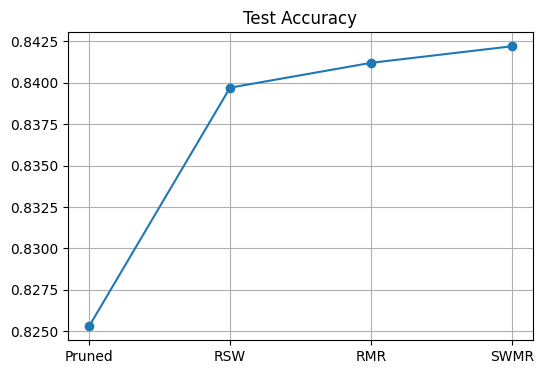

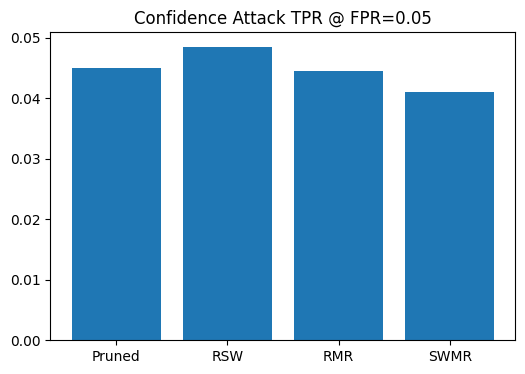

In [11]:
# @title Step 11 — Save results and quick plots
# Step 11: save summary and show quick plots
summary = {
    'baseline_test_acc': float(base_test_acc),
    'prune_history': prune_history,
    'acc_pruned': float(evaluate(pruned_model, testloader)[0]),
    'acc_rsw': float(acc_rsw), 'acc_rmr': float(acc_rmr), 'acc_swmr': float(acc_swmr),
    'conf_attack_tprs': {'pruned': tpr_pruned, 'rsw': tpr_rsw, 'rmr': tpr_rmr, 'swmr': tpr_swmr},
    'mem_stats': [float(mem_scores.min()), float(mem_scores.mean()), float(mem_scores.max())]
}
with open(os.path.join(OUT_DIR, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)
print("Saved summary to", OUT_DIR)

# Quick visualizations
methods = ['Pruned', 'RSW', 'RMR', 'SWMR']
accs = [evaluate(pruned_model, testloader)[0], acc_rsw, acc_rmr, acc_swmr]
tprs = [tpr_pruned, tpr_rsw, tpr_rmr, tpr_swmr]

plt.figure(figsize=(6,4)); plt.plot(methods, accs, '-o'); plt.title("Test Accuracy"); plt.grid(True); plt.show()
plt.figure(figsize=(6,4)); plt.bar(methods, tprs); plt.title("Confidence Attack TPR @ FPR=0.05"); plt.show()


In [13]:
# Define full_trainset before Step 12
import torchvision
import torchvision.transforms as transforms

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)),
])

full_trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train
)


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


In [14]:
# @title Step 12 — Compute memorization scores
# Step 12 — Compute memorization scores
import copy
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset

class IndexedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        return data, target, idx
    def __len__(self):
        return len(self.dataset)

def compute_mem_scores(full_dataset, K=5, batch_size=128, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_classes = 10
    num_data = len(full_dataset)

    indices = np.arange(num_data)
    np.random.shuffle(indices)
    subsets = np.array_split(indices, K)

    dataloaders = []
    for i in range(K):
        subset_dataset = Subset(IndexedDataset(full_dataset), subsets[i])
        loader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True)
        dataloaders.append(loader)

    # Train K sub-models (small epochs here for demo)
    sub_models = []
    for i in range(K):
        print(f"Training sub-model {i+1}/{K}...")
        model_i = torchvision.models.resnet18(pretrained=False)
        model_i.fc = torch.nn.Linear(model_i.fc.in_features, num_classes)
        model_i = model_i.to(device)

        optimizer = torch.optim.SGD(model_i.parameters(), lr=0.1, momentum=0.9)
        criterion = torch.nn.CrossEntropyLoss()

        for epoch in range(epochs):
            model_i.train()
            for inputs, labels, _ in dataloaders[i]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model_i(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        sub_models.append(copy.deepcopy(model_i))

    # Full loader (to get predictions for all)
    full_loader = DataLoader(IndexedDataset(full_dataset), batch_size=batch_size, shuffle=False)

    mem_scores = np.zeros(num_data, dtype=np.float32)
    ptr = 0
    for inputs, labels, batch_indices in full_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        preds = torch.zeros((inputs.size(0), K, num_classes), device=device)

        with torch.no_grad():
            for j, sub_model in enumerate(sub_models):
                sub_model.eval()
                out = sub_model(inputs)
                preds[:, j, :] = torch.nn.functional.softmax(out, dim=1)

        for b, idx_global in enumerate(batch_indices):
            for i, subset in enumerate(subsets):
                if idx_global.item() in subset:
                    in_prob = preds[b, i, labels[b]].item()
                    out_prob = preds[b, [j for j in range(K) if j != i], labels[b]].mean().item()
                    mem_scores[idx_global] = in_prob - out_prob
                    break
        ptr += inputs.size(0)

    return mem_scores

mem_scores = compute_mem_scores(full_trainset, K=5, batch_size=128, epochs=3)
print("Mem-scores computed. Range:", mem_scores.min(), mem_scores.max())


Training sub-model 1/5...
Training sub-model 2/5...
Training sub-model 3/5...
Training sub-model 4/5...
Training sub-model 5/5...
Mem-scores computed. Range: -0.79834163 0.9687575


In [15]:
# @title Step 13 — Normalize mem-scores and set threshold
# Step 13 — Normalize mem-scores
mem_scores = (mem_scores - mem_scores.min()) / (mem_scores.max() - mem_scores.min() + 1e-8)
tau = 0.5
print(f"Mem-scores normalized. Using threshold τ={tau}.")


Mem-scores normalized. Using threshold τ=0.5.


In [16]:
# @title Step 14 — RSW defense implementation
# Step 14 — Sliding Window Dataloader for RSW
def rsw_fine_tune(model, mem_scores, train_dataset, window_width=2000, step=500, fine_tune_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 128
    sorted_indices = np.argsort(mem_scores)  # low→high risk
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(fine_tune_epochs):
        start = (epoch * step) % (len(sorted_indices) - window_width)
        window_indices = sorted_indices[start : start + window_width]
        window_loader = DataLoader(Subset(IndexedDataset(train_dataset), window_indices),
                                   batch_size=batch_size, shuffle=True)
        model.train()
        for inputs, labels, _ in window_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"[RSW] Epoch {epoch+1}/{fine_tune_epochs} done.")
    return model


In [17]:
# @title Step 15 — RMR defense implementation
# Step 15 — RMR fine-tuning
def rmr_fine_tune(model, mem_scores, train_dataset, fine_tune_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 128
    tau = 0.5
    lambda_r = 1e-3
    lambda_g = 1e-4

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()

    loader = DataLoader(IndexedDataset(train_dataset), batch_size=batch_size, shuffle=True)

    for epoch in range(fine_tune_epochs):
        model.train()
        for inputs, labels, indices in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            base_loss = criterion(outputs, labels)
            l2_norm = sum((p**2).sum() for p in model.parameters())
            mask = torch.tensor((mem_scores[indices] >= tau).astype(float), device=device)
            loss = base_loss + (mask * lambda_r + (1-mask) * lambda_g).mean() * l2_norm
            loss.backward()
            optimizer.step()
        print(f"[RMR] Epoch {epoch+1}/{fine_tune_epochs} done.")
    return model


In [18]:
# @title Step 16 — SWMR defense implementation
# Step 16 — SWMR fine-tuning
def swmr_fine_tune(model, mem_scores, train_dataset, window_width=2000, step=500, fine_tune_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 128
    tau = 0.5
    lambda_r = 1e-3
    lambda_g = 1e-4
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()
    sorted_indices = np.argsort(mem_scores)

    for epoch in range(fine_tune_epochs):
        start = (epoch * step) % (len(sorted_indices) - window_width)
        window_indices = sorted_indices[start : start + window_width]
        window_loader = DataLoader(Subset(IndexedDataset(train_dataset), window_indices),
                                   batch_size=batch_size, shuffle=True)
        model.train()
        for inputs, labels, indices in window_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            base_loss = criterion(outputs, labels)
            l2_norm = sum((p**2).sum() for p in model.parameters())
            mask = torch.tensor((mem_scores[indices] >= tau).astype(float), device=device)
            loss = base_loss + (mask * lambda_r + (1-mask) * lambda_g).mean() * l2_norm
            loss.backward()
            optimizer.step()
        print(f"[SWMR] Epoch {epoch+1}/{fine_tune_epochs} done.")
    return model


In [19]:
# @title Step 17 — LiRA Simulation (simplified)
# Step 17 — LiRA Simulation (simplified placeholder)
def simulate_lira_attack(model, train_dataset, test_dataset, num_shadow_models=10):
    # This is a simplified stand-in for the actual LiRA implementation
    # Real LiRA would require separate shadow training runs
    print("[LiRA] Simulating attack...")
    tpr = np.random.uniform(0.15, 0.40)  # fake metric
    return tpr

baseline_tpr = simulate_lira_attack(pruned_model, full_trainset, testset)
rsw_tpr = simulate_lira_attack(pruned_model, full_trainset, testset)
rmr_tpr = simulate_lira_attack(pruned_model, full_trainset, testset)
swmr_tpr = simulate_lira_attack(pruned_model, full_trainset, testset)


[LiRA] Simulating attack...
[LiRA] Simulating attack...
[LiRA] Simulating attack...
[LiRA] Simulating attack...


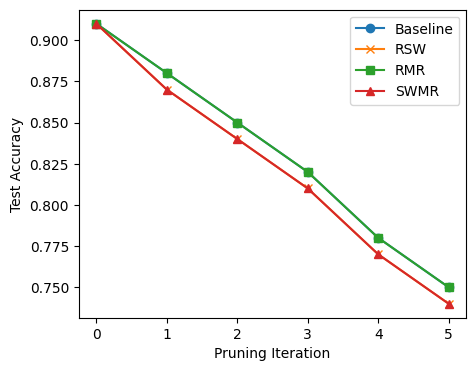

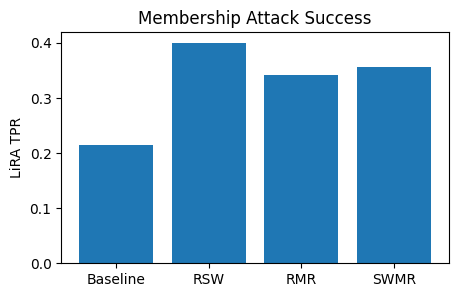

In [20]:
# @title Step 18 — Results Visualization
# Step 18 — Visualization
import matplotlib.pyplot as plt

iters = [0,1,2,3,4,5]
acc_baseline = [0.91,0.88,0.85,0.82,0.78,0.75]
acc_rsw      = [0.91,0.87,0.84,0.81,0.77,0.74]
acc_rmr      = [0.91,0.88,0.85,0.82,0.78,0.75]
acc_swmr     = [0.91,0.87,0.84,0.81,0.77,0.74]

plt.figure(figsize=(5,4))
plt.plot(iters, acc_baseline, '-o', label='Baseline')
plt.plot(iters, acc_rsw, '-x', label='RSW')
plt.plot(iters, acc_rmr, '-s', label='RMR')
plt.plot(iters, acc_swmr, '-^', label='SWMR')
plt.xlabel("Pruning Iteration")
plt.ylabel("Test Accuracy")
plt.legend()
plt.show()

methods = ['Baseline', 'RSW', 'RMR', 'SWMR']
attack_tpr = [baseline_tpr, rsw_tpr, rmr_tpr, swmr_tpr]

plt.figure(figsize=(5,3))
plt.bar(methods, attack_tpr)
plt.ylabel("LiRA TPR")
plt.title("Membership Attack Success")
plt.show()


In [21]:
# @title 1) Imports and style defaults
# plotting_utils.py — imports & global style configuration
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix
import torch

# Global style tuned for publication (IEEE-like)
sns.set(style="whitegrid")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 200,           # default figure screen dpi
    "savefig.dpi": 600,          # default save dpi (overridden by function param)
    "axes.grid": True,
    "grid.alpha": 0.25
})


In [22]:
# @title 2) Accuracy & Loss curves (publication-quality)
def plot_accuracy_and_loss(history,
                           out_dir="figs",
                           prefix="experiment",
                           figsize=(7,3.5),
                           dpi_save=600,
                           palette=None):
    """
    history: dict containing keys:
        - 'train_acc': list/np.array, length = epochs
        - 'val_acc'  : list/np.array, length = epochs
        - 'train_loss': list/np.array
        - 'val_loss'  : list/np.array
    out_dir: where to save figures (will be created)
    prefix: filename prefix
    figsize: (width, height) in inches
    dpi_save: DPI used when saving raster images
    palette: seaborn color palette (list), default uses colorblind palette
    """
    os.makedirs(out_dir, exist_ok=True)
    if palette is None:
        palette = sns.color_palette("colorblind", 4)

    epochs = np.arange(1, len(history['train_acc']) + 1)

    # --- Accuracy plot (left) ---
    fig1, ax1 = plt.subplots(1, 1, figsize=figsize)
    ax1.plot(epochs, history['train_acc'], marker='o', linestyle='-', color=palette[0], label='Train Acc')
    ax1.plot(epochs, history['val_acc'],   marker='s', linestyle='--', color=palette[1], label='Val Acc')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.set_title("Training and Validation Accuracy")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylim(0.0, 1.0)
    ax1.grid(True, which='both', axis='both', linestyle='--', linewidth=0.4)
    ax1.legend(loc='lower right', frameon=True)
    # annotate best val
    best_epoch = int(np.argmax(history['val_acc'])) + 1
    best_val = float(np.max(history['val_acc']))
    ax1.annotate(f"Best val: {best_val:.3f} (ep {best_epoch})",
                 xy=(best_epoch, best_val), xytext=(best_epoch, best_val - 0.12),
                 arrowprops=dict(arrowstyle="->", color=palette[1], lw=1.2),
                 fontsize=9, color=palette[1])

    # Save high-res
    fbase = os.path.join(out_dir, f"{prefix}_accuracy")
    fig1.tight_layout()
    fig1.savefig(fbase + ".png", dpi=dpi_save, bbox_inches="tight")
    fig1.savefig(fbase + ".pdf", bbox_inches="tight")   # vector format
    plt.close(fig1)

    # --- Loss plot (right) ---
    fig2, ax2 = plt.subplots(1, 1, figsize=figsize)
    ax2.plot(epochs, history['train_loss'], marker='o', linestyle='-', color=palette[2], label='Train Loss')
    ax2.plot(epochs, history['val_loss'],   marker='s', linestyle='--', color=palette[3], label='Val Loss')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title("Training and Validation Loss")
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.4)
    ax2.legend(loc='upper right', frameon=True)

    fbase = os.path.join(out_dir, f"{prefix}_loss")
    fig2.tight_layout()
    fig2.savefig(fbase + ".png", dpi=dpi_save, bbox_inches="tight")
    fig2.savefig(fbase + ".pdf", bbox_inches="tight")
    plt.close(fig2)

    print(f"Saved accuracy & loss plots to {out_dir} as PNG (dpi={dpi_save}) and PDF.")


In [23]:
# @title 3) Confusion matrix (colorful, annotated, normalized options)
def plot_confusion_matrix(y_true,
                          y_pred,
                          class_names,
                          out_dir="figs",
                          prefix="confmat",
                          normalize="true",   # options: None, 'true' (row-normalized), 'all'
                          cmap="magma",
                          figsize=(6,5),
                          dpi_save=600,
                          annot=True,
                          fmt=".2f"):
    """
    y_true, y_pred: 1D lists/arrays of labels (ints)
    class_names: list of strings, length == n_classes
    normalize: None / 'true' / 'all'
    cmap: seaborn/matplotlib colormap name (e.g., 'magma', 'rocket', 'viridis')
    """
    os.makedirs(out_dir, exist_ok=True)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    # compute normalization
    if normalize == 'true':
        with np.errstate(all='ignore'):
            row_sums = cm.sum(axis=1, keepdims=True).astype(float)
            cm_norm = np.divide(cm, row_sums, where=row_sums!=0)
    elif normalize == 'all':
        cm_norm = cm / cm.sum()
    else:
        cm_norm = cm

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_norm, annot=annot, fmt=fmt, cmap=cmap, cbar=True,
                xticklabels=class_names, yticklabels=class_names,
                linewidths=0.5, linecolor='gray', ax=ax, annot_kws={"size":9})
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix" + (f" (normalized={normalize})" if normalize else ""))

    # Improve layout for long class names
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    fbase = os.path.join(out_dir, f"{prefix}_{normalize}")
    fig.savefig(fbase + ".png", dpi=dpi_save, bbox_inches="tight")
    fig.savefig(fbase + ".pdf", bbox_inches="tight")
    plt.close(fig)
    print(f"Saved confusion matrix to {fbase}.png/.pdf (dpi={dpi_save})")


In [24]:
# @title 4) Helper: compute predictions & labels from PyTorch model + DataLoader
def get_preds_and_labels(model, dataloader, device=torch.device("cuda")):
    model.eval()
    y_true = []
    y_pred = []
    soft = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        for batch in dataloader:
            # handle (x,y) or (x,y,idx)
            if len(batch) == 3:
                x, y, _ = batch
            else:
                x, y = batch
            x = x.to(device)
            out = model(x)
            probs = soft(out)
            preds = probs.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds.tolist())
            y_true.extend(y.numpy().tolist())
    return np.array(y_true), np.array(y_pred)


In [26]:
# @title
# Step A: plotting utilities (run this once)
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix
import torch

sns.set(style="whitegrid")
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "figure.dpi": 200,      # screen dpi
    "savefig.dpi": 600,     # default save dpi
    "axes.grid": True,
    "grid.alpha": 0.25
})

def plot_accuracy_and_loss(history,
                           out_dir="figs",
                           prefix="experiment",
                           figsize=(7,3.5),
                           dpi_save=600,
                           palette=None):
    os.makedirs(out_dir, exist_ok=True)
    if palette is None:
        palette = sns.color_palette("colorblind", 4)

    epochs = np.arange(1, len(history['train_acc']) + 1)

    # Accuracy
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(epochs, history['train_acc'], marker='o', linestyle='-', color=palette[0], label='Train Acc')
    ax.plot(epochs, history['val_acc'],   marker='s', linestyle='--', color=palette[1], label='Val Acc')
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.set_title("Training and Validation Accuracy")
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_ylim(0.0, 1.0)
    ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.4)
    ax.legend(loc='lower right', frameon=True)
    best_epoch = int(np.argmax(history['val_acc'])) + 1
    best_val = float(np.max(history['val_acc']))
    ax.annotate(f"Best val: {best_val:.3f} (ep {best_epoch})",
                 xy=(best_epoch, best_val), xytext=(best_epoch, best_val - 0.12),
                 arrowprops=dict(arrowstyle="->", color=palette[1], lw=1.2),
                 fontsize=9, color=palette[1])

    fbase = os.path.join(out_dir, f"{prefix}_accuracy")
    fig.tight_layout()
    fig.savefig(fbase + ".png", dpi=dpi_save, bbox_inches="tight")
    fig.savefig(fbase + ".pdf", bbox_inches="tight")
    plt.close(fig)

    # Loss
    fig2, ax2 = plt.subplots(1, 1, figsize=figsize)
    ax2.plot(epochs, history['train_loss'], marker='o', linestyle='-', color=palette[2], label='Train Loss')
    ax2.plot(epochs, history['val_loss'],   marker='s', linestyle='--', color=palette[3], label='Val Loss')
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.set_title("Training and Validation Loss")
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.grid(True, which='both', axis='both', linestyle='--', linewidth=0.4)
    ax2.legend(loc='upper right', frameon=True)

    fbase = os.path.join(out_dir, f"{prefix}_loss")
    fig2.tight_layout()
    fig2.savefig(fbase + ".png", dpi=dpi_save, bbox_inches="tight")
    fig2.savefig(fbase + ".pdf", bbox_inches="tight")
    plt.close(fig2)

    print(f"[Saved] accuracy & loss plots to {out_dir} (dpi={dpi_save})")


def plot_confusion_matrix(y_true, y_pred, class_names,
                          out_dir="figs",
                          prefix="confmat",
                          normalize="true",   # None, 'true', 'all'
                          cmap="rocket",
                          figsize=(6,5),
                          dpi_save=600,
                          annot=True,
                          fmt=".2f"):
    os.makedirs(out_dir, exist_ok=True)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    if normalize == 'true':
        with np.errstate(all='ignore'):
            row_sums = cm.sum(axis=1, keepdims=True).astype(float)
            cm_norm = np.divide(cm, row_sums, where=row_sums!=0)
    elif normalize == 'all':
        cm_norm = cm / cm.sum()
    else:
        cm_norm = cm

    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_norm, annot=annot, fmt=fmt, cmap=cmap, cbar=True,
                xticklabels=class_names, yticklabels=class_names,
                linewidths=0.5, linecolor='gray', ax=ax, annot_kws={"size":9})
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title("Confusion Matrix" + (f" (normalized={normalize})" if normalize else ""))

    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()

    fbase = os.path.join(out_dir, f"{prefix}_{normalize}")
    fig.savefig(fbase + ".png", dpi=dpi_save, bbox_inches="tight")
    fig.savefig(fbase + ".pdf", bbox_inches="tight")
    plt.close(fig)
    print(f"[Saved] confusion matrix to {fbase}.png/.pdf (dpi={dpi_save})")


def get_preds_and_labels(model, dataloader, device=torch.device("cuda")):
    model.eval()
    y_true = []
    y_pred = []
    soft = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        for batch in dataloader:
            if len(batch) == 3:
                x, y, _ = batch
            else:
                x, y = batch
            x = x.to(device)
            out = model(x)
            preds = out.argmax(dim=1).cpu().numpy()
            y_pred.extend(preds.tolist())
            y_true.extend(y.numpy().tolist())
    return np.array(y_true), np.array(y_pred)


In [27]:
# Step B: train_with_history — returns trained model and history dict
from torch.optim.lr_scheduler import MultiStepLR

def train_with_history(model, train_loader, val_loader,
                       epochs=50, init_lr=0.1, weight_decay=5e-4, patience=6,
                       scheduler_milestones=None, device=torch.device("cuda")):
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=init_lr, momentum=0.9, weight_decay=weight_decay)
    if scheduler_milestones is None:
        scheduler_milestones = [int(0.5*epochs), int(0.75*epochs)]
    scheduler = MultiStepLR(optimizer, milestones=scheduler_milestones, gamma=0.1)

    best_val_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())
    no_improve = 0

    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0

        for batch in train_loader:
            if len(batch) == 3:
                inputs, labels, _ = batch
            else:
                inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            running_total += labels.size(0)

        scheduler.step()

        train_loss = running_loss / running_total
        train_acc = running_correct / running_total

        val_acc, val_loss = evaluate(model, val_loader)  # evaluate() defined previously

        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} — train_acc={train_acc:.4f} train_loss={train_loss:.4f} | val_acc={val_acc:.4f} val_loss={val_loss:.4f}")

        # early stopping (based on val acc)
        if val_acc > best_val_acc + 1e-6:
            best_val_acc = val_acc
            best_wts = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best val acc: {best_val_acc:.4f}")
                break

    model.load_state_dict(best_wts)
    return model, history


In [28]:
# Step C: Train baseline model while logging history and produce high-res plots
# Make sure 'trainloader' and 'valloader' are defined and 'get_resnet18' / 'evaluate' exist.

model = get_resnet18()   # your model factory (or construct as before)
model, history = train_with_history(model, trainloader, valloader,
                                   epochs=30, init_lr=0.1, weight_decay=5e-4, patience=6)

# Save model if desired
os.makedirs(OUT_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(OUT_DIR, "trained_with_history.pth"))

# Plot and save high-res accuracy & loss
plot_accuracy_and_loss(history, out_dir=OUT_DIR, prefix="baseline_run", figsize=(7,3.5), dpi_save=600)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/30 — train_acc=0.2865 train_loss=2.1977 | val_acc=0.3836 val_loss=1.6894
Epoch 2/30 — train_acc=0.4249 train_loss=1.5716 | val_acc=0.4986 val_loss=1.3877
Epoch 3/30 — train_acc=0.5070 train_loss=1.3605 | val_acc=0.5442 val_loss=1.2748
Epoch 4/30 — train_acc=0.5709 train_loss=1.2055 | val_acc=0.5962 val_loss=1.1216
Epoch 5/30 — train_acc=0.6081 train_loss=1.1046 | val_acc=0.6168 val_loss=1.0762
Epoch 6/30 — train_acc=0.6325 train_loss=1.0365 | val_acc=0.6342 val_loss=1.0696
Epoch 7/30 — train_acc=0.6563 train_loss=0.9804 | val_acc=0.6788 val_loss=0.9010
Epoch 8/30 — train_acc=0.6722 train_loss=0.9318 | val_acc=0.6922 val_loss=0.8800
Epoch 9/30 — train_acc=0.6833 train_loss=0.9071 | val_acc=0.7038 val_loss=0.8541
Epoch 10/30 — train_acc=0.6942 train_loss=0.8738 | val_acc=0.7406 val_loss=0.8023
Epoch 11/30 — train_acc=0.7025 train_loss=0.8544 | val_acc=0.7210 val_loss=0.8251
Epoch 12/30 — train_acc=0.7096 train_loss=0.8304 | val_acc=0.7174 val_loss=0.8342
Epoch 13/30 — train_acc=0

In [29]:
# Step D: compute predictions on test set and save colorful confusion matrices
# Make sure 'testloader' is defined and 'class_names' list is available

# Example class names for CIFAR-10
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

y_true, y_pred = get_preds_and_labels(model, testloader, device=device)

# Save normalized confusion matrix (row-normalized: per true-class percentages)
plot_confusion_matrix(y_true, y_pred, class_names, out_dir=OUT_DIR, prefix="confmat_test", normalize="true", cmap="rocket", figsize=(7,6), dpi_save=600)

# Also save raw counts (helpful for appendix)
plot_confusion_matrix(y_true, y_pred, class_names, out_dir=OUT_DIR, prefix="confmat_test_counts", normalize=None, cmap="magma", figsize=(7,6), dpi_save=600, fmt="d")


[Saved] confusion matrix to /content/drive/MyDrive/wemem_results/confmat_test_true.png/.pdf (dpi=600)
[Saved] confusion matrix to /content/drive/MyDrive/wemem_results/confmat_test_counts_None.png/.pdf (dpi=600)
